# MONODEPTH on Torch Hub ONNX model

WORK IN PROGRESS NOTEBOOK NOT FOR PUBLIC RELEASE

https://pytorch.org/hub/intelisl_midas_v2/

## Preparation 

### Install required Python\* packages

Run the cell below to install the Python\* packages necessary to run this demo. After installing the packages you can delete this cell. Note that installation may take a while. There is no progress indicator.

In [1]:
# # OpenVINO
# !pip install --quiet --index-url https://test.pypi.org/simple --extra-index-url https://pypi.org/simple openvino-dev
# # PyTorch - see https://pytorch.org/get-started for other options
# !pip install --quiet  torch==1.8.0+cpu torchvision==0.9.0+cpu  -f https://download.pytorch.org/whl/torch_stable.html
# # Other packages
# !pip install --quiet matplotlib youtube_dl Pillow

### Imports

In [2]:
import copy
import os
import time
import urllib
from base64 import b64encode
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import youtube_dl
from IPython.display import HTML
from openvino.inference_engine import IECore
from PIL import Image

### Settings

In [3]:
precision = "FP16"
device = "CPU"
model_name = "MiDaS_small"
# model_name = "MiDaS"
onnx_model_name = model_name + ".onnx"

C:\Users\havanden\openvino_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load model from Torch Hub and convert to onnx

In [4]:
midas = torch.hub.load("intel-isl/MiDaS", model_name, progress=False)
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
if "small" in model_name:
    transform = midas_transforms.small_transform
else:
    transform = midas_transforms.default_transform

Using cache found in c:\Users\havanden/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in c:\Users\havanden/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in c:\Users\havanden/.cache\torch\hub\intel-isl_MiDaS_master


In [5]:
dummy_input = np.random.rand(800, 800, 3)
dummy_input = transform(dummy_input)
torch.onnx.export(midas, dummy_input, onnx_model_name, opset_version=11)
print(dummy_input.shape)

c:\Users\havanden/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master\geffnet\conv2d_layers.py:46: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  return max((-(i // -s) - 1) * s + (k - 1) * d + 1 - i, 0)


torch.Size([1, 3, 256, 256])


## Load model and get model information

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

In [6]:
ie = IECore()
net = ie.read_network(onnx_model_name)
exec_net = ie.load_network(network=net, device_name="CPU")

input_key = list(exec_net.input_info)[0]
output_key = list(exec_net.outputs.keys())[0]

## Monodepth on Image

### Load, resize and reshape input image

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). 

In [7]:
# Download and load an image
# Image source: https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F02rgn06&id=470c2f96cb938855
image_url = r"https://farm6.staticflickr.com/3880/15127053318_be969c3a58_o.jpg"
urllib.request.urlretrieve(image_url, "image.jpg")


image = cv2.imread("image.jpg")[:, :, (2, 1, 0)]  # (2,1,0) changes the channels from BGR to RGB
input_image = transform(image)
input_image.shape

torch.Size([1, 3, 256, 192])

In [8]:
# reshape the network to the image size
net.reshape({input_key: input_image.shape})
exec_net = ie.load_network(network=net, device_name=device)

### Do inference on image

In [9]:
result = exec_net.infer(inputs={input_key: input_image})[output_key].squeeze(0)
resized_result = cv2.resize(
    result, image.shape[:2][::-1]
)  # resize back to original image shape. cv2.resize expects shape in (width, height), [::-1] reverses the (height, width) shape to match this.

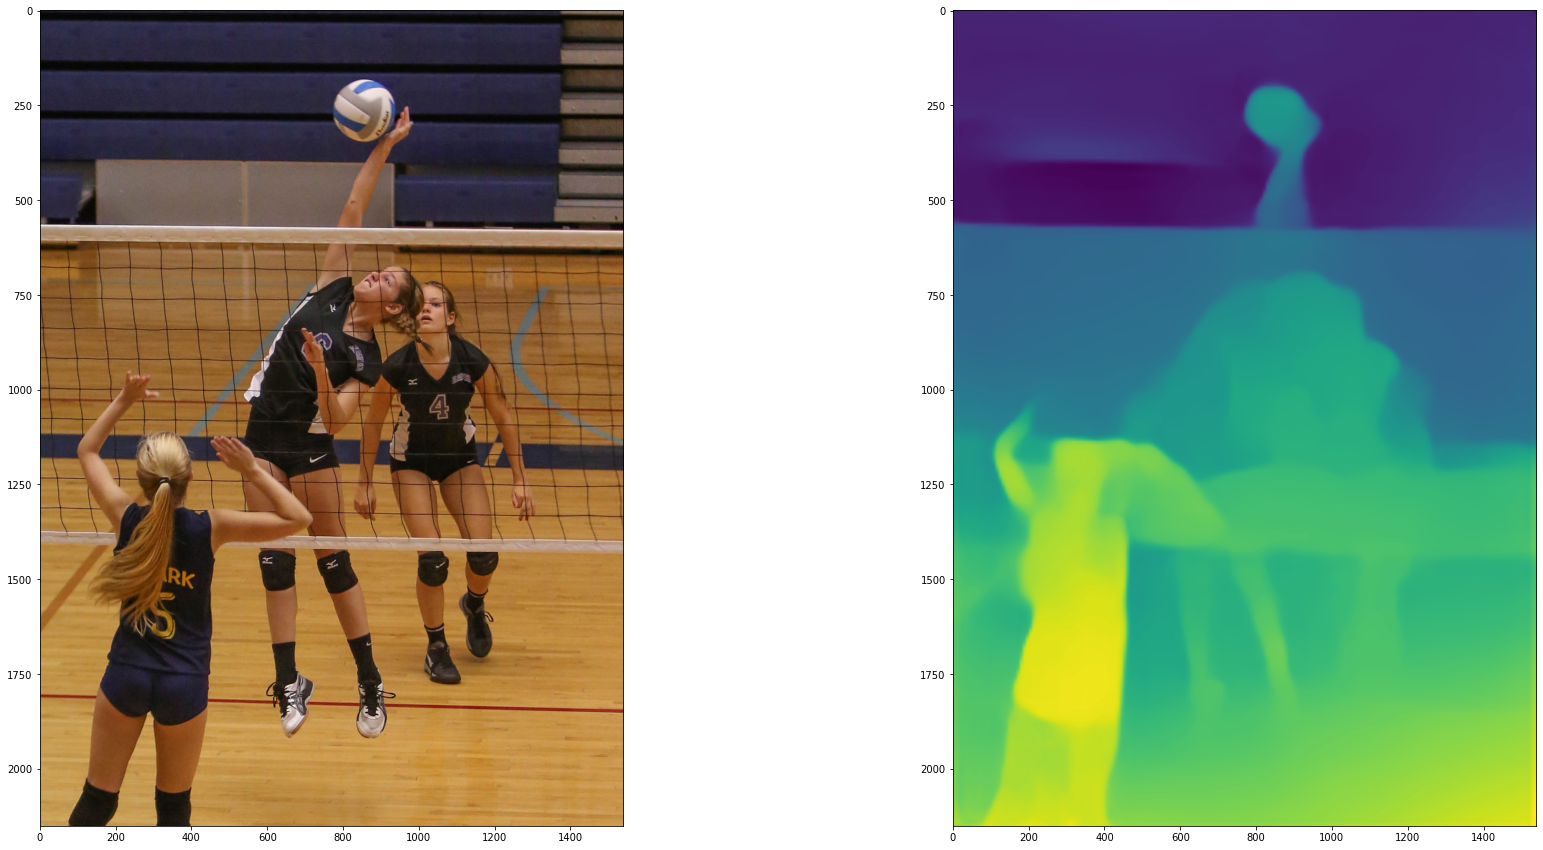

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15))
ax[0].imshow(image)
ax[1].imshow(resized_result);

## Monodepth on Video

DEBUG: Uses Youtube_DL for quickly downloading a video from Youtube. Current video is not meant as demo video!

Reads first 1200 frames from video. Change NUM_FRAMES below to modify this.

In [11]:
NUM_FRAMES = 1200

# Use youtube_dl to download a video. It downloads to the videos subdirectory. You can also place a local video there and comment out the last three lines
video_dir = "videos"
video_name = "pink"
video_ext = ".mkv"  #DEBUG
download_video_path = os.path.join(video_dir, video_name)
video_path = download_video_path + video_ext

# Comment this out if the video in video_path already exists
video_url = "https://youtu.be/BMDxbn5HDf8"
with youtube_dl.YoutubeDL({"outtmpl": download_video_path, "start_time":45}) as ydl:
    ydl.download([video_url])

[youtube] BMDxbn5HDf8: Downloading webpage
[youtube] BMDxbn5HDf8: Downloading player 223a7479


[download] Destination: videos/pink.f134
[download] 100% of 17.50MiB in 00:0043MiB/s ETA 00:00known ETA
[download] Destination: videos/pink.f251
[download] 100% of 7.80MiB in 00:0028MiB/s ETA 00:009
[ffmpeg] Merging formats into "videos/pink.mkv"
Deleting original file videos/pink.f134 (pass -k to keep)
Deleting original file videos/pink.f251 (pass -k to keep)


In [12]:
resultlist = []
i = 0
start_time = time.time()
cap = cv2.VideoCapture(video_path)
while cap.isOpened():
    ret, image = cap.read()
    if not ret:
        cap.release()
        break
    if i == NUM_FRAMES:
        break
    i = i + 1
    image = image[:, :, (2, 1, 0)]  # convert from RGB to BGR
    original_image = copy.deepcopy(image)
    height, width, _ = original_image.shape

    # Resize the image to network input shape
    input_image = transform(image)
    if i == 1:
        net.reshape({input_key: input_image.shape})
        exec_net = ie.load_network(network=net, device_name=device)

    result = exec_net.infer(inputs={input_key: input_image})[output_key].squeeze(0)

    resultlist.append((original_image, result))
end_time = time.time()
duration = end_time - start_time

print(f"Inference of {i} frames took {duration:.3f} seconds")
print(f"{model_name} - latency: {duration/NUM_FRAMES:.2f} sec., fps: {NUM_FRAMES/duration:.2f}")

Inference of 1200 frames took 23.080 seconds
MiDaS_small - latency: 0.02 sec., fps: 51.99


### Write monodepth video to file

In [13]:
def normalize_minmax(data):
    return (data - data.min()) / (data.max() - data.min())

In [14]:
result_video_path = f"{video_path[:-len(video_ext)]}_monodepth_{model_name}.avi"

cap = cv2.VideoCapture(video_path)
out_video = cv2.VideoWriter(
    result_video_path,
    cv2.VideoWriter_fourcc("M", "J", "P", "G"),
    cap.get(cv2.CAP_PROP_FPS),
    (width * 2, height),
)
cap.release()
for originalframe, resultframe in resultlist:
    videoframe = normalize_minmax(resultframe)
    videoframe = matplotlib.cm.viridis(videoframe)[:, :, :3] * 255

    videoframe = videoframe.astype(np.uint8)
    videoframe = cv2.resize(videoframe, (width, height))

    stacked_frame = np.hstack((originalframe[:, :, (2, 1, 0)], videoframe))
    out_video.write(stacked_frame)
out_video.release()

### Display monodepth video

DEBUG: Colab requires compressing the video before displaying it. See https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-col
This requires ffmpeg. For webinar we will not require this.ab

In [15]:
compressed_video_path = result_video_path + "_compressed.mp4"
! ffmpeg -i $result_video_path -vcodec libx264 $compressed_video_path -hide_banner -loglevel error -y

In [16]:
mp4 = open(compressed_video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(
    """
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
"""
    % data_url
)